##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples. 

This notebook assumes you are familiar with Pix2Pix, which you can learn about in the [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix). The code for CycleGAN is similar, the main difference is an additional loss function, and the use of unpaired training data.

CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain. 

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All you need is the source and the target dataset (which is simply a directory of images).

![Output Image 1](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_1.png?raw=1)
![Output Image 2](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_2.png?raw=1)

## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [1]:
!pip install --help


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

Description:
  Install packages from:
  
  - PyPI (and other indexes) using requirement specifiers.
  - VCS project urls.
  - Local project directories.
  - Local or remote source archives.
  
  pip also supports installing from "requirements files", which provide
  an easy way to specify a whole environment to be installed.

Install Options:
  -r, --requirement <file>    Install from the given requirements file. This
                              option can be used multiple times.
  -c, --constraint <file>     Constrain versions using the given constraints
                              file. This option can be used multiple times.
  --no-deps                   Don't install p

In [5]:
!pip3 install tensorflow

  Using cached https://files.pythonhosted.org/packages/35/55/a0dbd642e68e68f3e309d1413abdc0a7aa7e1534c79c0fc2501defb864ac/tensorflow-2.1.0-cp37-cp37m-macosx_10_11_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c3/fd/1e86bc4837cc9a3a5faf3db9b1854aa04ad35b5f381f9648fbe81a6f94e4/google_pasta-0.1.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/85/7a/ae480be23b768910a9327c33517ced4623ba88dc035f9ce0206657c353a9/scipy-1.4.1-cp37-cp37m-macosx_10_6_intel.whl
  Using cached https://files.pythonhosted.org/packages/4c/25/c057a298635d08d087a20f51ff4287d821814208ebb045d84ea65535b3e3/protobuf-3.11.3-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2f/5b/2cc2b9285e8b2ca8d2c1e4a2cbf1b12d70a2488ea78170de1909bca725f2/numpy-1.18.1-cp37-cp37m-macosx_10_9_x8

In [3]:
!pip3 install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/l3/zj4dwbfn7l1f7hls1nqfvpm80000gp/T/pip-req-build-whujt8ka
  Using cached https://files.pythonhosted.org/packages/1a/53/9243c600e047bd4c3df9e69cfabc1e8004a82cac2e0c484580a78a94ba2a/absl-py-0.9.0.tar.gz
  Running setup.py install for absl-py ... - \ | done
  Running setup.py install for tensorflow-examples ... - \ | done


In [18]:
!pip3 install -q tensorflow tensorflow-datasets matplotlib

In [17]:
import tensorflow as tf


In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import numpy as np #Julius
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [22]:
#dataset, metadata = tfds.load('cycle_gan/horse2zebra',
#                             with_info=True, as_supervised=True)


# In the following I download my Cosmology pictures (for once only one file)
# zebras are the cosmology pattern that is projected on the cosmology of horses

# In order to come along with the pix2pix gen and dis which are coded for
# 3 input channels I introduce (1000,128,128,3) zero arrays and fill
# [:,:,:0] up with the corresponding data

train_np_zebras=np.load('/Users/Julius_Frey1/thesis/maps/0.101_1.304/kappa_map_cosmo_0.101_1.304_0_total_num_1000.npy')
train_np_horses=np.load('/Users/Julius_Frey1/thesis/maps/0.269_0.534/kappa_map_cosmo_0.269_0.534_0_total_num_1000.npy')

test_np_zebras=np.load('/Users/Julius_Frey1/thesis/maps/0.101_1.304/kappa_map_cosmo_0.101_1.304_10_total_num_1000.npy')
test_np_horses=np.load('/Users/Julius_Frey1/thesis/maps/0.269_0.534/kappa_map_cosmo_0.269_0.534_10_total_num_1000.npy')

test_np_zebras=np.expand_dims(test_np_zebras, axis=3)    
test_np_horses=np.expand_dims(test_np_horses, axis=3)
train_np_zebras=np.expand_dims(train_np_zebras, axis=3)
train_np_horses=np.expand_dims(train_np_horses, axis=3)

'''three_te_np_ze = np.zeros((1000,128,128,3)) Neglected in order to stay with initial date
three_te_np_ho = np.zeros((1000,128,128,3))
three_tr_np_ze = np.zeros((1000,128,128,3))
three_tr_np_ho = np.zeros((1000,128,128,3))

three_te_np_ze[:, : , :, 0] = test_np_zebras[:,:,:,0]
three_te_np_ho[:, : , :, 0] = test_np_horses[:,:,:,0]
three_tr_np_ze[:, : , :, 0] = train_np_zebras[:,:,:,0]
three_tr_np_ho[:, : , :, 0] = train_np_horses[:,:,:,0]

three_te_np_ze = three_te_np_ze.astype(np.float32)
three_te_np_ho = three_te_np_ho.astype(np.float32)
three_tr_np_ze = three_tr_np_ze.astype(np.float32)
three_tr_np_ho = three_tr_np_ho.astype(np.float32)

train_zebras=tf.data.Dataset.from_tensor_slices(three_tr_np_ze)
train_horses=tf.data.Dataset.from_tensor_slices(three_tr_np_ho)

test_zebras=tf.data.Dataset.from_tensor_slices(three_te_np_ze)
test_horses=tf.data.Dataset.from_tensor_slices(three_te_np_ho)'''

train_np_zebras = train_np_zebras.astype(np.float32)
train_np_horses = train_np_horses.astype(np.float32)
test_np_zebras = test_np_horses.astype(np.float32)
test_np_orses = test_np_zebras.astype(np.float32)

train_zebras=tf.data.Dataset.from_tensor_slices(train_np_zebras)
train_horses=tf.data.Dataset.from_tensor_slices(train_np_horses)

test_zebras=tf.data.Dataset.from_tensor_slices(test_np_zebras)
test_horses=tf.data.Dataset.from_tensor_slices(test_np_horses)



#tf.shape(tf.expand_dims(train_zebras, 2))

#train_horses, train_zebras = dataset['trainA'], dataset['trainB']
#test_horses, test_zebras = dataset['testA'], dataset['testB']


<TensorSliceDataset shapes: (128, 128, 1), types: tf.float32>

In [24]:
BUFFER_SIZE = 900
BATCH_SIZE = 1
IMG_WIDTH = 128 #256
IMG_HEIGHT = 128 #256

In [25]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [26]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1 #127.5
  return image

In [27]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  #image = tf.image.resize(image, [286, 286],
  #                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 128 x 128 x 3 # 256x256
  #image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [28]:
def preprocess_image_train(image):
 # image = tf.image.resize(image, [256, 256]) NEW!!!
  image = image - tf.math.reduce_mean(image, axis=[1,2], keepdims=True) #Julius Is that right???
  #image = random_jitter(image)
  #image = normalize(image)
  return image

In [29]:
def preprocess_image_test(image):
  #image = normalize(image)
  #image = tf.image.resize(image, [256, 256])  NEW!!!
  image = image - tf.math.reduce_mean(image, axis=[1,2], keepdims=True)
  return image

In [30]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(1)

In [31]:
test_zebras

<BatchDataset shapes: (None, 128, 128, 1), types: tf.float32>

In [32]:
sample_horse = next(iter(train_horses))
#sample_zebra = tf.concat([next(iter(train_zebras)) , t1 , t1], 3)
sample_zebra = next(iter(train_zebras))

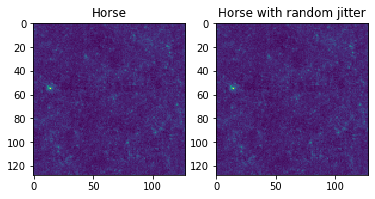

In [33]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0,:,:,0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(sample_horse[0,:,:,0] * 0.5 + 0.5) #randomjitter

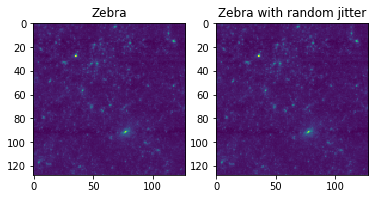

In [34]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0,:,:,0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(sample_zebra[0,:,:,0] * 0.5 + 0.5) # randomjitter

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [35]:
OUTPUT_CHANNELS=1

In [36]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

In [37]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [38]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [39]:
def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      #downsample(512, 4, norm_type),  # (bs, 1, 1, 512)  JULIUS FREY
  ]

  up_stack = [
      #upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024) JULIUS FREY
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 1])  # JULIUS FREY
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [40]:
generator = unet_generator(1, norm_type='batchnorm')
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [41]:
def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image') # JULIUS FREY from 3 to 1
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 1], name='target_image') #JULIUS FREY from 3 to 1
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

In [42]:
discriminator2 = discriminator()
tf.keras.utils.plot_model(discriminator2, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [43]:
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

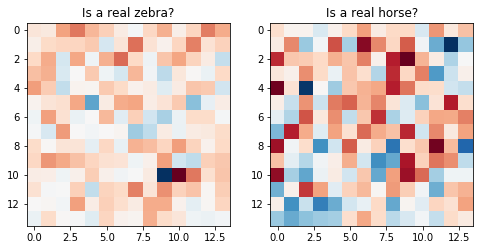

In [44]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [45]:

LAMBDA = 10

In [46]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [47]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [48]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [49]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [50]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [51]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [52]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate. 

In [53]:
EPOCHS = 200

In [54]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input, prediction]   ### Julius Frey: actually, it was test_input[0], prediction[0]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i][0,:,:,0] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [55]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [56]:
tf.data.Dataset.zip((train_horses, train_zebras))


<ZipDataset shapes: ((None, 128, 128, 1), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [57]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

...

KeyboardInterrupt: 

## Generate using test dataset

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

In [ ]:
tf.keras.models.save_model(
    generator_g,
    'gdrive/My Drive/Masterarbeit',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

In [ ]:
new_model = tf.keras.models.load_model(
    '/content/gdrive/My Drive/Masterarbeit/',
    custom_objects=None,
    compile=True
)

In [ ]:
for inp in test_horses.take(5):
  generate_images(new_model, inp)

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.